## 8.2 Univariate CNN Models

### 8.2.1 Data Preparation


The CNN model will learn a function that maps a sequence of past observations as input to an output observation.

The split sequence() function below implements this behavior and will split a given univariate sequence into multiple samples where each sample has a specified number of time steps and the output is a single time step.

In [4]:
from numpy import array
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [5]:
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# summarize the data
for i in range(len(X)):
    print(X[i], y[i])

[10 20 30] 40
[20 30 40] 50
[30 40 50] 60
[40 50 60] 70
[50 60 70] 80
[60 70 80] 90


Running the example splits the univariate series into six samples where each sample has three input time steps and one output time step.

### 8.2.2 CNN Model

1. A one-dimensional CNN is a CNN model that has a convolutional hidden layer that operates over a 1D sequence. 
2. If you have very long input sequences, and then a pooling layer whose job it is to distill the output of the convolutional layer to the most salient elements. 
3. The convolutional and pooling layers are followed by a dense fully connected layer that interprets the features extracted by the convolutional part of the model. 
4. A flatten layer is used between the convolutional layers and the dense layer to reduce the feature maps to a single one-dimensional vector. 

In [11]:
# univariate cnn example
from numpy import array 
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import Flatten 
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D 

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# define model 
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=1000, verbose=0)

#demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[101.22242]]


In this model, we define a convolutional layer with 64 filter maps and a kernel size of 2. This is followed by a max pooling layer and a dense layer to interpret the input feature. An output layer is specified that predicts a single numerical value. The model is fit using the efficient Adam version of stochastic gradient descent and optimized using the mean squared error, or ‘mse’, loss function. 

## 8.3 Multivariate CNN Models
### 8.3.1 Multiple Input Series

- CNNs can support parallel input time series as separate channels, like red, green, and blue components of an image. Therefore, we need to split the data into samples maintaining the order of observations across the two input sequences.
- the choice of the size of the number of input time steps will have an important effect on how much of the training data is used. 
- We can see that the X component has a three-dimensional structure. The first dimension is __the number of samples__, in this case 7. The second dimension is __the number of time steps per sample__, in this case 3, the value specified to the function. Finally, the last dimension specifies __the number of parallel time series or the number of variables__, in this case 2 for the two parallel series. This is the exact three-dimensional structure expected by a 1D CNN as input. 

Running the example prints the dataset with one row per time step and one column for each of the two input and one output parallel time series. <br>
[[ 10 15 25] <br> 
 [ 20 25 45] <br>
 [ 30 35 65] <br>
 [ 40 45 85] <br>
 [ 50 55 105] <br>
 [ 60 65 125] <br>
 [ 70 75 145] <br>
 [ 80 85 165] <br>
 [ 90 95 185]]

If we chose three input time steps, then the first sample would look as follows: <br>
Input: <br>
10, 15 <br>
20, 25 <br>
30, 35 <br>
Output: <br>
65

#### CNN Model

In [37]:
# multivariate cnn exmaple 
from numpy import array 
from numpy import hstack 
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix, :-1], sequence[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequence(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

# define model 
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model 
model.fit(X, y, epochs=1000, verbose=0)
# demonstrate prediction
x_input = array([[80, 85], [90, 95], [100, 105]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[207.78607]]


#### Multi-headed CNN Model

- There is another, more elaborate way to model the problem. Each input series can be handled by a separate CNN and the output of each of these submodels can be combined before a prediction is made for the output sequence.  We can refer to this as a __multi-headed CNN model__
-  Both input submodels have been defined, we can merge the output from each model into one long vector which can be interpreted before making a prediction for the output sequence.

In [38]:
from keras.layers import Input
from keras.models import Model
from keras.layers.merge import concatenate

# one time series per head 
n_features = 1 
# separate input data
X1 = X[:, :, 0].reshape(X.shape[0], X.shape[1], n_features)
X2 = X[:, :, 1].reshape(X.shape[0], X.shape[1], n_features)
# first input model 
visible1 = Input(shape=(n_steps, n_features))
cnn1 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible1)
cnn1 = MaxPooling1D(pool_size=2)(cnn1)
cnn1 = Flatten()(cnn1)
# second input model 
visible2 = Input(shape=(n_steps, n_features))
cnn2 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible2)
cnn2 = MaxPooling1D(pool_size=2)(cnn2)
cnn2 = Flatten()(cnn2)
# merge input models 
merge = concatenate([cnn1, cnn2])
dense = Dense(50, activation='relu')(merge)
output = Dense(1)(dense)
model = Model(inputs=[visible1, visible2], outputs=output)
model.compile(optimizer='adam', loss='mse')
# fit model 
model.fit([X1, X2], y, epochs=1000, verbose=0)
# demonstrate prediction
x_input = array([[80, 85], [90, 95], [100, 105]])
x1 = x_input[:, 0].reshape((1, n_steps, n_features))
x2 = x_input[:, 1].reshape((1, n_steps, n_features))
yhat = model.predict([x1, x2], verbose=0)
print(yhat)

[[206.10701]]


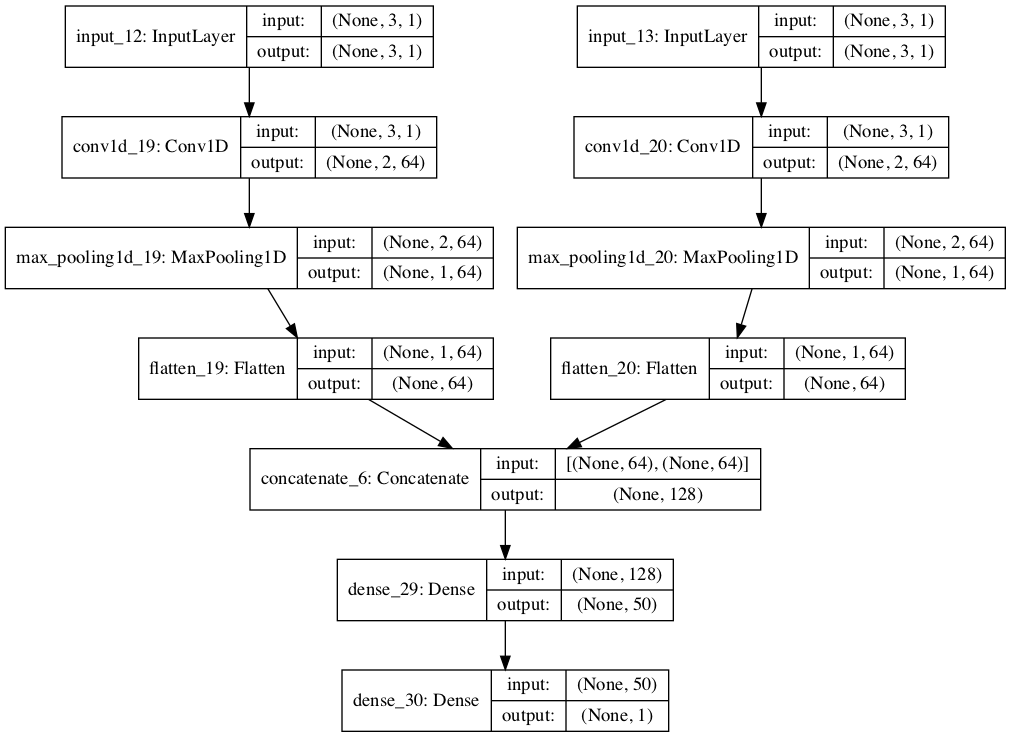

In [40]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot_Multi-headed.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_plot_Multi-headed.png')

### 8.3.2 Multiple Parallel Series


An alternate time series problem is the case where there are multiple parallel time series and a value must be predicted for each. This might be referred to as multivariate forecasting.<br>
[[ 10 15 25] <br>
 [ 20 25 45] <br>
 [ 30 35 65] <br> 
 [ 40 45 85] <br>
 [ 50 55 105] <br>
 [ 60 65 125] <br>
 [ 70 75 145] <br>
 [ 80 85 165] <br>
 [ 90 95 185]] <br>

The first sample of this dataset would be: <br>
Input: <br>
10, 15, 25 <br>
20, 25, 45 <br>
30, 35, 65 <br>
Output: <br>
40, 45, 85 <br>

#### Vector-Output CNN Model

In [25]:
# multivariate output 1d cnn example 
from numpy import array 
from numpy import hstack 
from keras.models import Sequential
from keras.layers import Dense 
from keras.layers import Flatten 
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a multivariate sequence into samples 
def split_sequences(sequences, n_steps):
    X, y = [], []
    for i in range(len(sequences)):
        # find the end of this pattern 
        end_idx = i + n_steps
        # check if we are beyond the dataset
        if end_idx > len(sequences) - 1:
            break 
        # gather input and output parts of the pattern 
        seq_x, seq_y = sequences[i:end_idx, :], sequences[end_idx, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

# define model 
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
#fit model
model.fit(X, y, epochs=3000, verbose=0)
# demonstrate prediction
x_input = array([[70,75,145], [80,85,165], [90,95,185]]) 
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[100.97242 106.74308 207.64502]]


It is very closed to answer [[100, 105, 205]]

#### Multi-output CNN Model

- As with multiple input series, there is another more elaborate way to model the problem. Each output series can be handled by a separate output CNN model. We can refer to this as a multi-output CNN model.

In [31]:
# multivariate output 1d cnn example
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps
    # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

# separate output
y1 = y[:, 0].reshape((y.shape[0], 1))
y2 = y[:, 1].reshape((y.shape[0], 1))
y3 = y[:, 2].reshape((y.shape[0], 1))
# define model
visible = Input(shape=(n_steps, n_features))
cnn = Conv1D(filters=64, kernel_size=2, activation='relu')(visible) 
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn = Flatten()(cnn)
cnn = Dense(50, activation='relu')(cnn)
# define output 1
output1 = Dense(1)(cnn)
# define output 2
output2 = Dense(1)(cnn)
# define output 3
output3 = Dense(1)(cnn)
# tie together
model = Model(inputs=visible, outputs=[output1, output2, output3]) 
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, [y1,y2,y3], epochs=2000, verbose=0)
# demonstrate prediction
x_input = array([[70,75,145], [80,85,165], [90,95,185]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[array([[101.26983]], dtype=float32), array([[106.70283]], dtype=float32), array([[207.69539]], dtype=float32)]


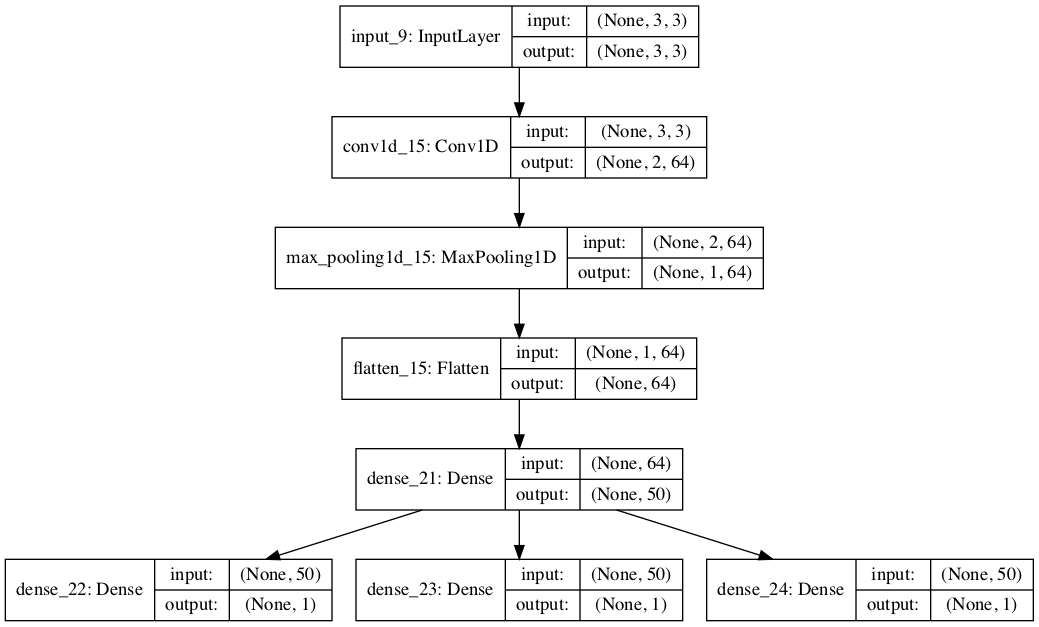

In [35]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot_Multi-outputCNN.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_plot_Multi-outputCNN.png')

## 8.4 Multi-step CNN Models
In practice, there is little difference to the 1D CNN model in predicting a vector output that represents different output variables (as in the previous example), or a vector output that represents multiple time steps of one variable. Nevertheless, there are subtle and important differences in the way the training data is prepared.

### 8.4.1 Data Preparation
As with one-step forecasting, a time series used for multi-step time series forecasting must be split into samples with input and output components. Both the input and output components will be comprised of multiple time steps and may or may not have the same number of steps. For example, given the univariate time series:<br>
[10, 20, 30, 40, 50, 60, 70, 80, 90]<br>
Input:<br>
[10, 20, 30] <br>
output:<br>
[40, 50]

### 8.4.2 Vector Output Model

The CNN expects data to have a three-dimensional structure of [samples, timesteps, features]

In [41]:
# univariate multi-step vector-output 1d cnn example
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in,
n_features)))
model.add(MaxPooling1D(pool_size=2)) 
model.add(Flatten())
model.add(Dense(50, activation='relu')) 
model.add(Dense(n_steps_out)) 
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=2000, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features)) 
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[101.69177 113.09064]]


We would expect the predicted output to be: [100, 110]. As expected by the model, the shape of the single sample of input data when making the prediction must be [1, 3, 1] for the 1 sample, 3 time steps of the input, and the single feature.

## 8.5 Multivariate Multi-step CNN Models

In the previous sections, we have looked at univariate, multivariate, and multi-step time series forecasting. It is possible to mix and match the different types of 1D CNN models presented so far for the different problems. This too applies to time series forecasting problems that involve multivariate and multi-step forecasting, but it may be a little more challenging. In this section, we will explore short examples of data preparation and modeling for multivariate multi-step time series forecasting as a template to ease this challenge, specifically:
1. Multiple Input Multi-step Output.
2. Multiple Parallel Input and Multi-step Output.

### 8.5.1 Multiple Input Multi-step Output

There are those multivariate time series forecasting problems where the output series is separate but dependent upon the input time series, and multiple time steps are required for the output series. For example, consider our multivariate time series from a prior section:<br>
[[ 10 15 25] <br>
 [ 20 25 45] <br>
 [ 30 35 65] <br>
 [ 40 45 85] <br>
 [ 50 55 105] <br>
 [ 60 65 125] <br>
 [ 70 75 145] <br>
 [ 80 85 165] <br>
 [ 90 95 185]] <br>
 
input:<br>
10, 15 <br>
20, 25 <br>
30, 35 <br>
output: <br>
65 <br>
85 <br>

In [44]:
# multivariate multi-step 1d cnn example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in,
n_features)))
model.add(MaxPooling1D(pool_size=2)) 
model.add(Flatten())
model.add(Dense(50, activation='relu')) 
model.add(Dense(n_steps_out)) 
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=2000, verbose=0)
# demonstrate prediction
x_input = array([[70, 75], [80, 85], [90, 95]]) 
x_input = x_input.reshape((1, n_steps_in, n_features)) 
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[186.64403 206.98767]]


Running the example fits the model and predicts the next two time steps of the output sequence beyond the dataset. We would expect the next two steps to be [185, 205].

### 8.5.2 Multiple Parallel Input and Multi-step Output

A problem with parallel time series may require the prediction of multiple time steps of each time series. For example, consider our multivariate time series from a prior section: <br>
[[ 10 15 25] <br>
 [ 20 25 45] <br>
 [ 30 35 65] <br>
 [ 40 45 85] <br>
 [ 50 55 105] <br>
 [ 60 65 125] <br>
 [ 70 75 145] <br>
 [ 80 85 165] <br>
 [ 90 95 185]] <br>
 
input: <br>
10, 15, 25 <br>
20, 25, 45 <br>
30, 35, 65 <br>
output: <br>
40, 45, 85 <br>
50, 55, 105 <br>

We can now develop a 1D CNN model for this dataset. We will use a vector-output model in this case. As such, we must flatten the three-dimensional structure of the output portion of each sample in order to train the model. This means, instead of predicting two steps for each series, __the model is trained on and expected to predict a vector of six numbers directly__.

In [45]:
# multivariate output multi-step 1d cnn example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# flatten output
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in,
n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu')) 
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=7000, verbose=0)
# demonstrate prediction
x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]]) 
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[ 90.66969   96.18741  186.74968  101.41485  106.485565 207.95026 ]]


Running the example fits the model and predicts the values for each of the three time steps for the next two time steps beyond the end of the dataset. We would expect the values for these series and time steps to be as follows:<br>
[[90, 95, 185], <br>
[100, 105, 205]]

## 8.7 Further Reading
This section provides more resources on the topic if you are looking to go deeper.

### 8.7.1 Books
- Deep Learning, 2016. https://amzn.to/2MQyLVZ
- Deep Learning with Python, 2017. https://amzn.to/2vMRiMe

### 8.7.2 Papers
- Backpropagation Applied to Handwritten Zip Code Recognition, 1989. https://ieeexplore.ieee.org/document/6795724/
- Gradient-based Learning Applied to Document Recognition, 1998. https://ieeexplore.ieee.org/document/726791/
- Very Deep Convolutional Networks for Large-Scale Image Recognition, 2014. https://arxiv.org/abs/1409.1556

### 8.7.3 APIs
- Keras: The Python Deep Learning library. https://keras.io/
- Getting started with the Keras Sequential model. https://keras.io/getting-started/sequential-model-guide/
- Getting started with the Keras functional API. https://keras.io/getting-started/functional-api-guide/
- Keras Sequential Model API. https://keras.io/models/sequential/
- Keras Core Layers API. https://keras.io/layers/core/
- Keras Convolutional Layers API. https://keras.io/layers/convolutional/
- Keras Pooling Layers API. https://keras.io/layers/pooling/

## 8.8 Summary
In this tutorial, you discovered how to develop a suite of CNN models for a range of standard time series forecasting problems. Specifically, you learned:
- How to develop CNN models for univariate time series forecasting.
- How to develop CNN models for multivariate time series forecasting. 
- How to develop CNN models for multi-step time series forecasting.
